# Scalp Type Image Classifier using ResNet50v2 

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob 
import tensorflow as tf
import PIL
from PIL import ImageDraw

from keras import models
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten, Activation, BatchNormalization,Input,Add,ZeroPadding2D,AveragePooling2D,GlobalMaxPooling2D,MaxPool2D
from keras import optimizers
from keras import regularizers
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.applications.resnet_v2 import EfficientNetB0, preprocess_input, decode_predictions
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions


from sklearn.metrics import confusion_matrix

Train_data, Validation, Test >> dandruff, erythema, hairloss, folliculitis, oily_scalp, dry_scalp 총 6가지 두피 타입 이미지 데이터셋이 있음

### dry_scalp 이미지 데이터 불러오기

In [27]:
train_path = '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp'
valid_path = '/content/drive/MyDrive/Final_Project/Validation/dry_scalp'
test_path = '/content/drive/MyDrive/Final_Project/Test/dry_scalp'


### oily_scalp 이미지 데이터 불러오기

In [28]:
# train_path = '/content/drive/MyDrive/Final_Project/Train_data/oily_scalp'
# valid_path = '/content/drive/MyDrive/Final_Project/Validation/oily_scalp'
# test_path = '/content/drive/MyDrive/Final_Project/Test/oily_scalp'


### dandruff 이미지 불러오기

In [29]:
# train_path = '/content/drive/MyDrive/Final_Project/Train_data/dandruff'
# valid_path = '/content/drive/MyDrive/Final_Project/Validation/dandruff'
# test_path = '/content/drive/MyDrive/Final_Project/Test/dandruff'

### erythema 이미지 불러오기

In [30]:
# train_path = '/content/drive/MyDrive/Final_Project/Train_data/erythema'
# valid_path = '/content/drive/MyDrive/Final_Project/Validation/erythema'
# test_path = '/content/drive/MyDrive/Final_Project/Test/erythema'

### folliculitis 이미지 불러오기


In [31]:
# train_path = '/content/drive/MyDrive/Final_Project/Train_data/folliculitis'
# valid_path = '/content/drive/MyDrive/Final_Project/Validation/folliculitis'
# test_path = '/content/drive/MyDrive/Final_Project/Test/folliculitis'


### hairloss 이미지 불러오기

In [32]:
# train_path = '/content/drive/MyDrive/Final_Project/Train_data/folliculitis'
# valid_path = '/content/drive/MyDrive/Final_Project/Validation/folliculitis'
# test_path = '/content/drive/MyDrive/Final_Project/Test/folliculitis'

------------------------------

### Image generator

In [33]:
subject = train_path.split('/')[-1]
subject

'dry_scalp'

In [34]:
# image labels

labels=pd.Series(os.listdir(train_path))

labels=labels.sort_values()
labels=labels.to_list()
labels

['dry_scalp_0', 'dry_scalp_1', 'dry_scalp_2', 'dry_scalp_3']

In [35]:
image_height = 224  # 이미지 높이
image_width = 224   # 이미지 넓이
batch_size = 64     # batch size
epochs  = 20  # trining 횟수

In [36]:
# ImageDataGenerator 클래스를 통해 train_datagen, val_datagen 인스턴스를 생성.
# 픽셀 값을 0~1 범위로 변환

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
# train_datagen 인스턴스를 통해 train dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 training_set 객체를 생성.
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


# val_datagen 인스턴스를 통해 test dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_set 객체를 생성.
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='categorical')

#val_datagen 인스턴스를 통해 val dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 val_set 객체를 생성.
val_set = val_datagen.flow_from_directory(valid_path,
                                           target_size=(image_width, image_height),
                                           batch_size=batch_size,
                                           shuffle=False,
                                           class_mode='categorical')

Found 20438 images belonging to 4 classes.
Found 1819 images belonging to 4 classes.
Found 3188 images belonging to 4 classes.


In [38]:
class_path = glob.glob(train_path + '/*')
class_path

['/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_2',
 '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_3',
 '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_1',
 '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_0']

In [39]:
# 각각의 data set 이 만들어 내는 이미지의 클래스 인덱스 확인
print(f'train set의 이미지 클래스: {train_set.class_indices}')
print(f'test set의 이미지 클래스: {test_set.class_indices}')
print(f'validation set의 이미지 클래스: {val_set.class_indices}')

train set의 이미지 클래스: {'dry_scalp_0': 0, 'dry_scalp_1': 1, 'dry_scalp_2': 2, 'dry_scalp_3': 3}
test set의 이미지 클래스: {'dry_scalp_0': 0, 'dry_scalp_1': 1, 'dry_scalp_2': 2, 'dry_scalp_3': 3}
validation set의 이미지 클래스: {'dry_scalp_0': 0, 'dry_scalp_1': 1, 'dry_scalp_2': 2, 'dry_scalp_3': 3}


In [40]:
classNum = []
fileNum = []
for path in class_path :
    fileNum.append(len(glob.glob(path + '/*')))
    classNum.append(int(path.split('_')[-1]))

label_dic = dict(zip(classNum, fileNum))
label_dic

{0: 4588, 1: 4435, 2: 5486, 3: 5929}

### 모델링

In [41]:
conv_base = EfficientNetB0(classes=4, weights = None, input_shape=(224,224,3))
model = conv_base
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [42]:
# model.summary()

In [45]:
# optimizer 정의

opt = tf.keras.optimizers.Adam(learning_rate= 0.0001,beta_1=0.9, beta_2=0.999,epsilon=1e-07)

In [46]:
# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint('/content/drive/MyDrive/Final_Project/윤건우/Weight/EfficientNetB0_dry_scalp2.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_acc', patience=7)

# callback 정의
callbacks= [modelCheckpoint,monitor_val_acc]

In [47]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['acc'])

In [48]:
resnet50v2_history =model.fit_generator(train_set,
                    steps_per_epoch=2400//batch_size,
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=800//batch_size,
                    callbacks=callbacks
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
37/37 [==============================] - 266s 7s/step - loss: 2.1676 - acc: 0.2724 - val_loss: 1.4714 - val_acc: 0.0000e+00
Epoch 2/20
37/37 [==============================] - 229s 6s/step - loss: 1.9519 - acc: 0.2846 - val_loss: 1.7029 - val_acc: 0.0000e+00
Epoch 3/20
37/37 [==============================] - 199s 5s/step - loss: 1.8264 - acc: 0.3171 - val_loss: 1.4766 - val_acc: 0.0000e+00
Epoch 4/20
37/37 [==============================] - 172s 5s/step - loss: 1.8919 - acc: 0.3117 - val_loss: 1.4772 - val_acc: 0.0000e+00
Epoch 5/20
37/37 [==============================] - 157s 4s/step - loss: 1.7592 - acc: 0.3125 - val_loss: 1.0098 - val_acc: 1.0000
Epoch 6/20
37/37 [==============================] - 134s 4s/step - loss: 1.6268 - acc: 0.3370 - val_loss: 1.7919 - val_acc: 0.0000e+00
Epoch 7/20
37/37 [==============================] - 125s 3s/step - loss: 1.6109 - acc: 0.3539 - val_loss: 1.1300 - val_acc: 1.0000
Epoch 8/20
37/37 [==============================] - 109s 3s/ste

In [ ]:
# 성능이 가장 우수했던 모델 호출
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Final_Project/박건희/Model/EfficientNetB0_xxx.h5')

In [49]:
# resnet_model 모델 평가
(test_loss, test_accuracy) = model.evaluate(test_set, steps=800//batch_size, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy*100)

12/12 [==============================] - 218s 20s/step - loss: 1.9289 - acc: 0.0625
Test loss: 1.9289398193359375
Test accuracy: 6.25


In [50]:
# font 설정

font1 = {'family': 'DejaVu Sans',
         'weight': 'bold',
         'size': 20
         }

font2 = {'family': 'DejaVu Sans',
         'size': 16
         }   

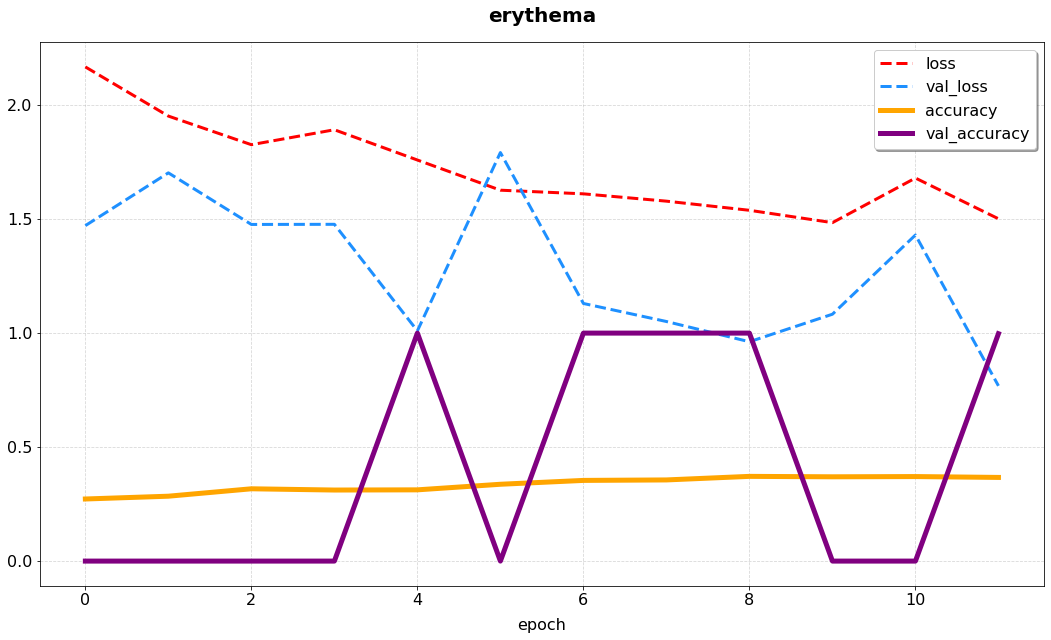

In [51]:
plt.figure(figsize=(18,10))

plt.plot(resnet50v2_history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(resnet50v2_history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(resnet50v2_history.history['acc'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(resnet50v2_history.history['val_acc'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('erythema', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_set)
classes = test_set.classes[test_set.index_array]
y_pred = np.argmax(Y_pred, axis=1)

result_dict = dict(map(reversed, test_set.class_indices.items()))
class_names = list(result_dict.values())

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))

print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))

-- Confusion Matrix --
[[ 74   2   0   0]
 [610  23   0   0]
 [765  19   0   0]
 [320   6   0   0]]
-- Classification Report --
              precision    recall  f1-score   support

 dry_scalp_0       0.04      0.97      0.08        76
 dry_scalp_1       0.46      0.04      0.07       633
 dry_scalp_2       0.00      0.00      0.00       784
 dry_scalp_3       0.00      0.00      0.00       326

    accuracy                           0.05      1819
   macro avg       0.13      0.25      0.04      1819
weighted avg       0.16      0.05      0.03      1819



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d' )
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title(f'{subject}_confusion matrix')